In [1]:
import pandas as pd
import numpy as np
import itertools
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, KMeans, OPTICS
import pyPLNmodels
from pyPLNmodels.models import PlnPCAcollection, Pln, ZIPln

import predictive_plots,predictive_clustering,utils


#### Importing scales data

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

scales_BEBRASK = pd.read_excel("../Datasets/RETOS_scales.xlsx")
scales_RETOS = pd.read_excel("../Datasets/BEBRASK_scales.xlsx")
scales = pd.concat([scales_BEBRASK, scales_RETOS])
scales = scales.query("EPRIME_CODE != 'PREDWELL_RETOS-307-1'")
cols = scales.columns
#We convert all data to numeric, and change to NaN those values that can not be converted
scales[cols[3:]] = scales[cols[3:]].apply(pd.to_numeric, errors='coerce') 


In [3]:
#Grouping the metrics that will be evaluated from scales for the BEBRASK and RETOS dataset (as the rest were no used
#or contain to many NaNs
PANAS = ["PA", "NA."]
ERQ = ["ERQ_CR", "ERQ_ES"]
UPPSP = ["UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV"]
BIS_BAS = ["BIS", "BAS_D", "BAS_RR", "BAS_FS"]
TEPS = ["TEPS_AF", "TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum", "RRQ_Ref"]
ASI3 = ["ASI_P", "ASI_C", "ASI_S"]
SPQ = ["SPQ", "SPQ_IR"]
MSSB = ["MSSB_POS", "MSSB_NEG", "MSSB_DES"]

list_metrics = [PANAS, ERQ, UPPSP, BIS_BAS, TEPS, SHS, FS, LOTR, RRQ, ASI3, SPQ, MSSB]

## Prediction on Rating0 on RETOS & BEBRASK on the Baselina Dataset


In [4]:
baseline = pd.read_excel("RETOS_BEBRASK_Baseline.xlsx")
baseline

,Subject,Mean_Rating0,Dif_Match,Cor_Pred_Like
0,PREDWELL_RETOS-1-1,2.888889,1.614379,0.113495
1,PREDWELL_RETOS-10-1,2.533333,1.117647,0.214781
2,PREDWELL_RETOS-1001-1,2.644444,1.494553,0.336312
3,PREDWELL_RETOS-1002-1,2.711111,1.318083,0.450822
4,PREDWELL_RETOS-1003-1,2.200000,1.424837,0.073526
...,...,...,...,...
144,PREDWELL_RETOS-5-1,2.377778,1.300654,0.225374
145,PREDWELL_RETOS-6-1,2.266667,1.152505,0.499722
146,PREDWELL_RETOS-7-1,2.444444,1.352941,0.426911
147,PREDWELL_RETOS-8-1,2.555556,1.117647,0.186173


#### Distribution of variables

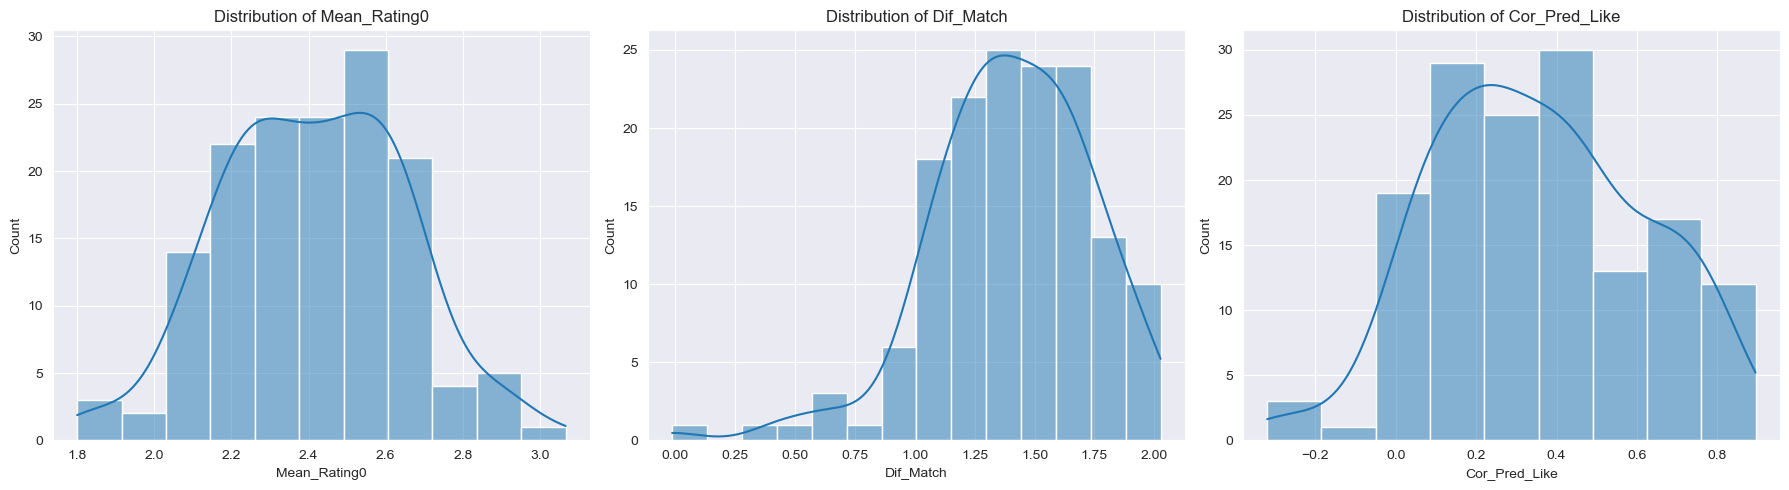

In [5]:
predictive_plots.plot_distributions(baseline)


#### Correlation of variables

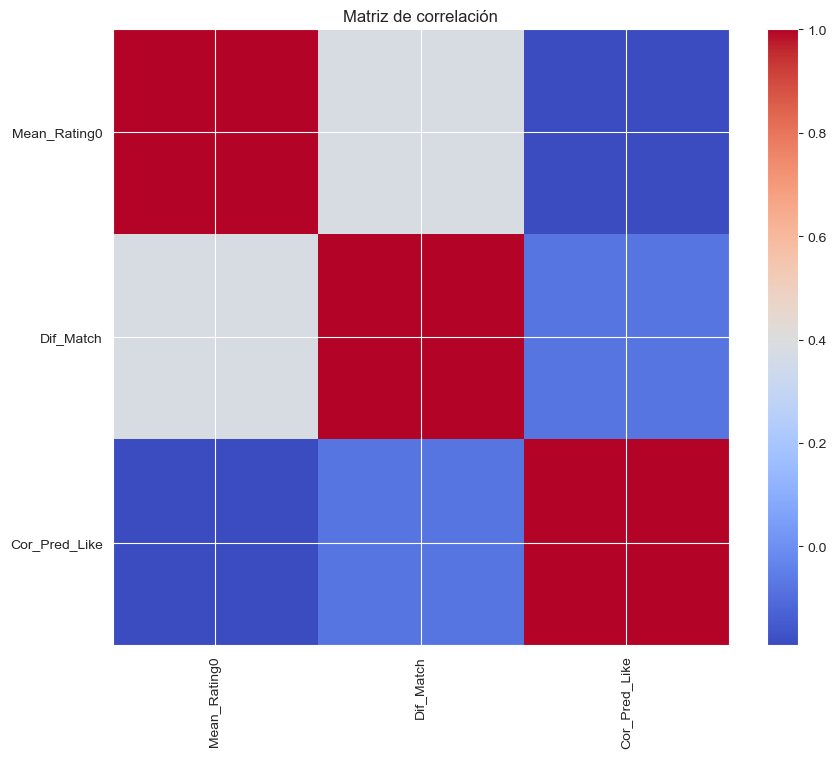

In [6]:
predictive_plots.plot_correlation(baseline)


### Clustering Baseline

In [7]:
#Normalization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(baseline.drop("Subject",axis=1))
scaled_df = pd.DataFrame(scaled_data)

#### Hierarchical

In [8]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(scaled_df,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(scaled_df, data_clusters))
    db.append(davies_bouldin_score(scaled_df, data_clusters))


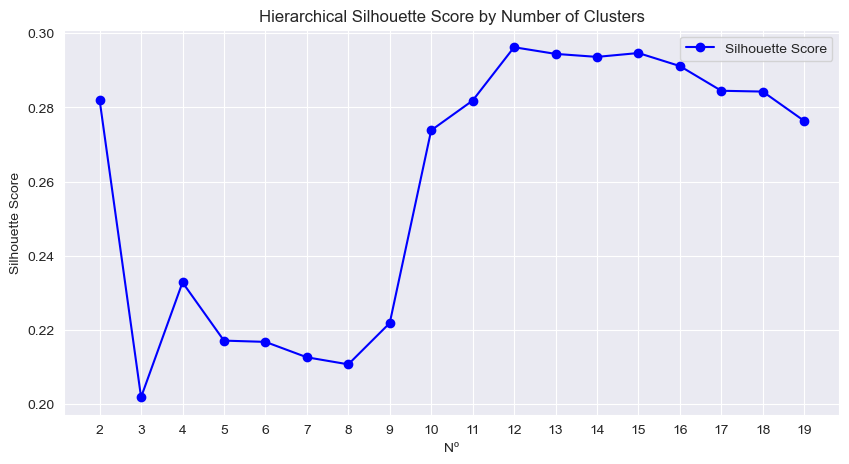

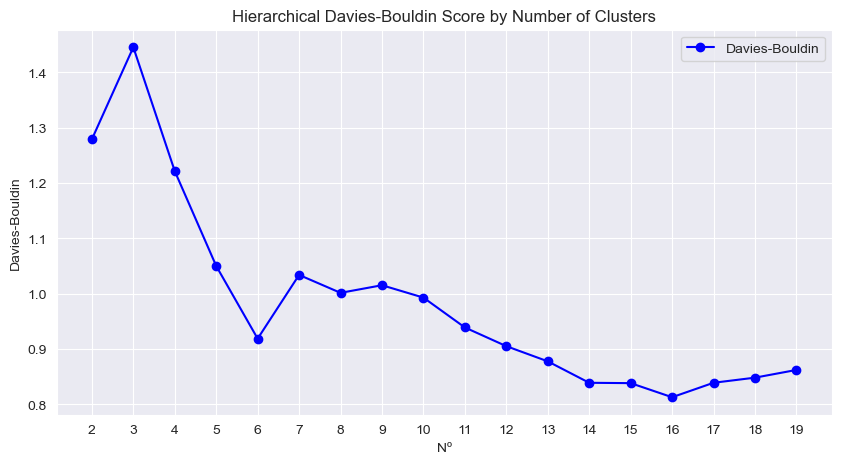

In [9]:
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)


In [10]:
for n in range(2,7):
    data_clusters = predictive_clustering.clustering(scaled_df,AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    df_cluster = pd.concat([baseline["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"baseline_hierarchical_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    output_name = f'Clusters_CountData/baseline_hierarchical_{n}_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)


#### OPTICS

In [11]:
silhouette = []
db = []
for n in range(4,10):
    
    data_clusters = predictive_clustering.clustering(scaled_df,OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    
    
    copy_df = scaled_data.copy()
    copy_df = pd.DataFrame(copy_df)

    copy_df["clusters"] = data_clusters
    copy_df = copy_df[copy_df["clusters"] != -1]
    silhouette.append(silhouette_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))
    db.append(davies_bouldin_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))




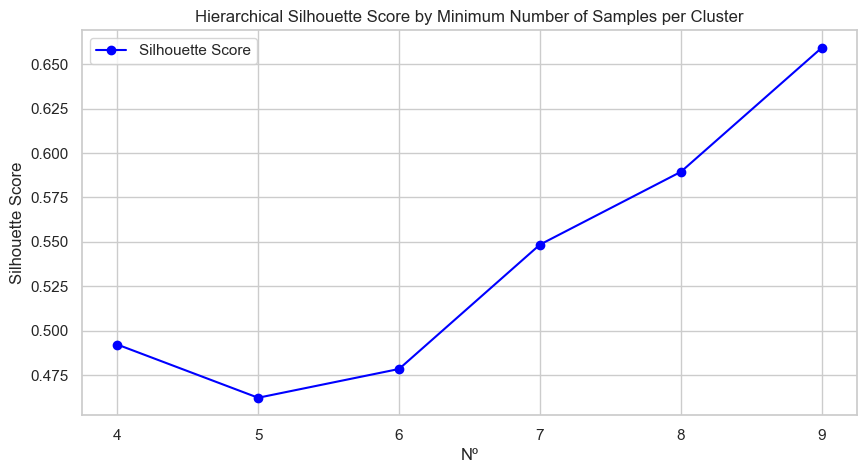

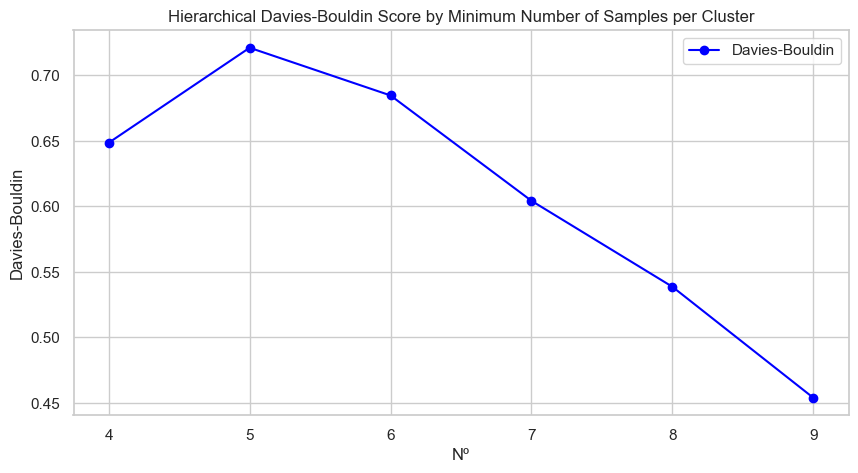

In [12]:

cluster_range = range(4, 10)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, silhouette, label, title)

cluster_range = range(4, 10)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, db, label, title)


In [13]:
for n in range(4,8):
    data_clusters = predictive_clustering.clustering(scaled_df,OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    df_cluster = pd.concat([baseline["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"baseline_optics_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    output_name = f'Clusters_CountData/baseline_optics_{n}_per_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)

## Prediction on Rating0 on RETOS & BEBRASK on Count Dataset

In [14]:
data = pd.read_excel("RETOS_BEBRASK_Rating0_count.xlsx")
data

,Subject,Count_Happy_1_1,Count_Happy_1_2,Count_Happy_1_3,Count_Happy_1_4,Count_Happy_0_1,Count_Happy_0_2,Count_Happy_0_3,Count_Happy_0_4,Count_Sad_1_1,...,Count_Sad_0_3,Count_Sad_0_4,Count_Fear_1_1,Count_Fear_1_2,Count_Fear_1_3,Count_Fear_1_4,Count_Fear_0_1,Count_Fear_0_2,Count_Fear_0_3,Count_Fear_0_4
0,PREDWELL_RETOS-1-1,0,0,1,8,5,0,0,1,0,...,2,1,0,3,1,5,3,1,1,1
1,PREDWELL_RETOS-10-1,0,1,4,4,4,2,0,0,0,...,1,0,1,1,3,4,1,3,1,1
2,PREDWELL_RETOS-101-1,0,1,2,6,5,1,0,0,1,...,1,0,2,1,3,3,5,1,0,0
3,PREDWELL_RETOS-102-1,1,0,4,4,6,0,0,0,1,...,0,3,0,2,3,4,4,2,0,0
4,PREDWELL_RETOS-103-1,0,1,1,7,5,1,0,0,0,...,1,0,3,2,3,1,3,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-1124-1,0,3,2,4,3,3,0,0,2,...,0,0,1,3,5,0,5,0,1,0
145,PREDWELL_RETOS-1125-1,0,0,3,6,5,1,0,0,0,...,1,0,1,3,2,3,2,3,1,0
146,PREDWELL_RETOS-1126-1,0,1,2,6,6,0,0,0,2,...,2,0,0,3,1,5,3,0,1,2
147,PREDWELL_RETOS-1127-1,0,0,2,7,4,2,0,0,0,...,1,0,1,3,1,4,2,3,1,0


#### Distribution of variables

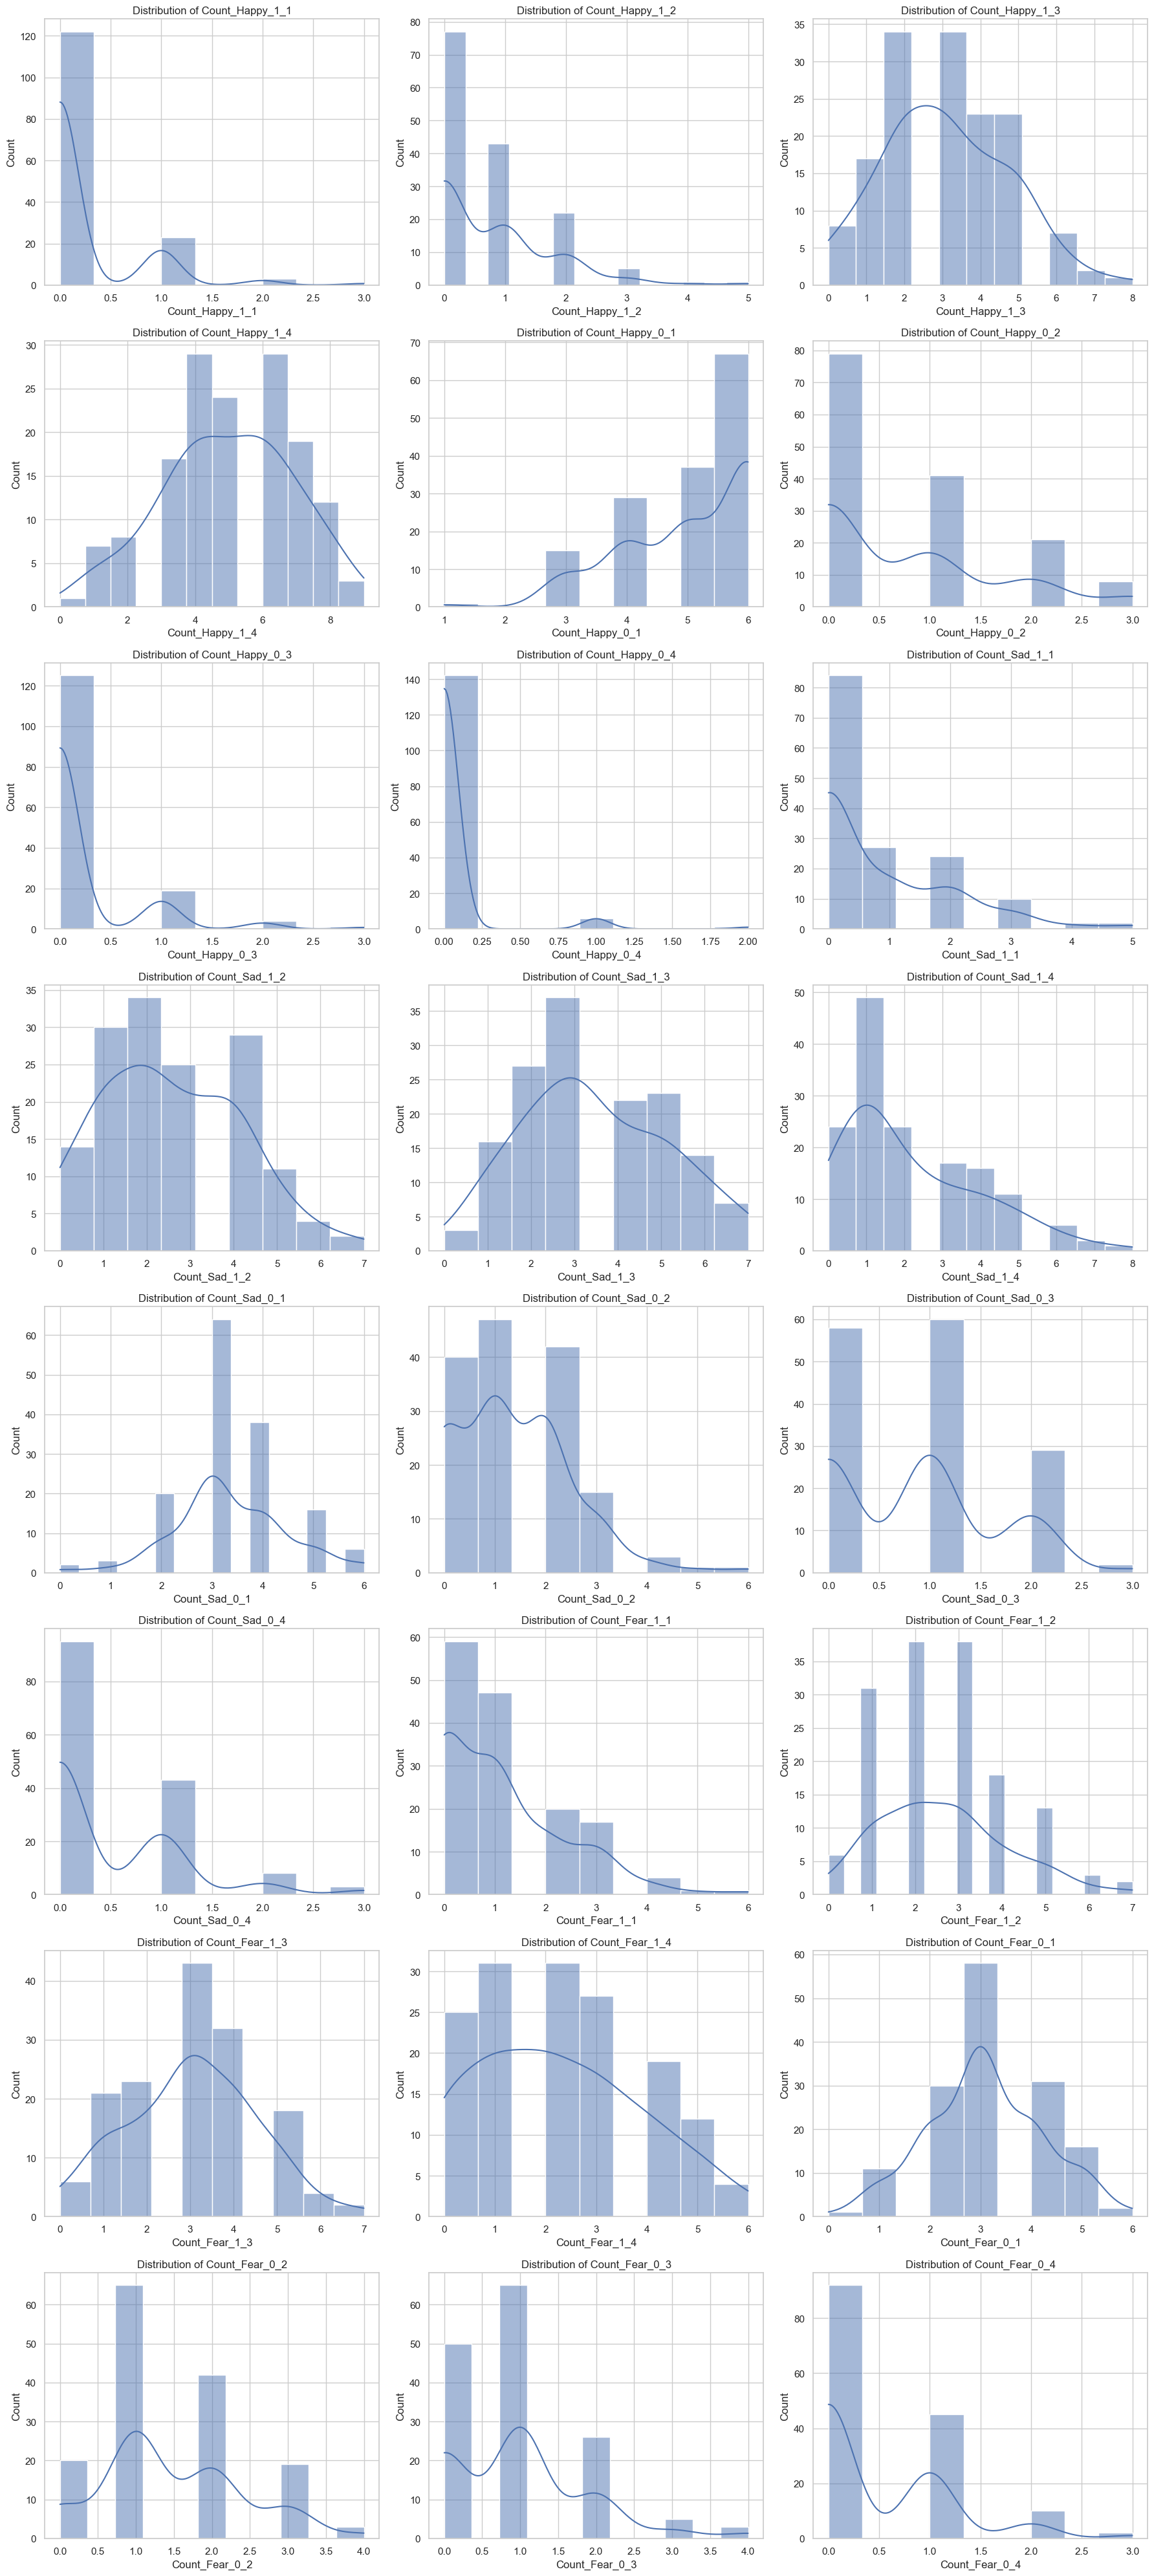

In [15]:
predictive_plots.plot_distributions(data)

#### Correlation of variables


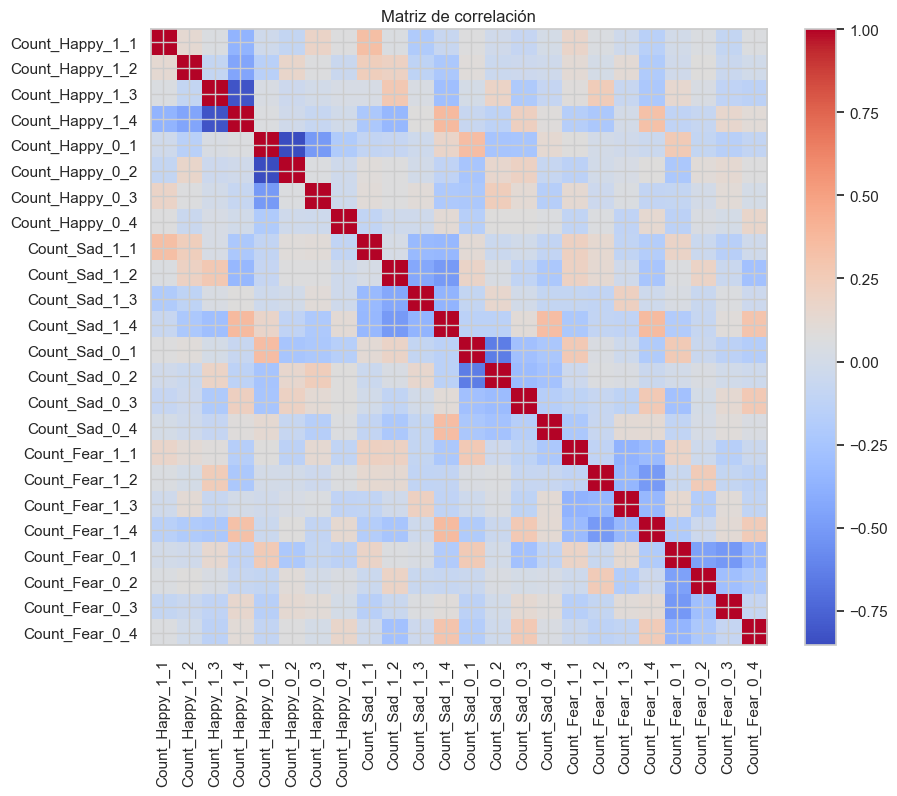

In [16]:
predictive_plots.plot_correlation(data)


In general, positive correlations can be observed between different emotions that maintain the same match and have the same score. Negative correlations are observed between the count variables of the same emotion and the same match (the 4x4 matrices that are generated around the diagonal).

### PLN-PCA Transformation

Given that count data follows a Poisson process, we can use Poisson-lognormal transformation to have normal data. As the count data matrix is quite sparse, we can also use the zero inflated formula that takes into account the higher amount of 0 in the dataset when transforming. 

In [17]:
data = data.sort_values(by='Subject').reset_index(drop=True)

In [18]:
from pyPLNmodels.models import PlnPCAcollection, Pln, ZIPln

In [19]:
tasks = {}
tasks["counts"] = data.drop(["Subject"],axis=1).values
tasks["correlation"] = baseline["Cor_Pred_Like"].values
tasks["Dif_Match"] = baseline["Dif_Match"]


zi = ZIPln(endog = tasks["counts"],exog=baseline[["Cor_Pred_Like","Dif_Match"]])
zi.fit()
transformed_data = zi.transform()
transformed_data = np.array(transformed_data)
df_transformed_data = pd.DataFrame(transformed_data)


scaler = StandardScaler()
scaled_transformed_data = scaler.fit_transform(df_transformed_data)
scaled_transformed_df = pd.DataFrame(scaled_transformed_data)


scaled_transformed_df.insert(0,"Subject",data["Subject"].copy())

Setting the offsets to zero
Fitting a ZIPln model with full covariance model and zero-inflation.
Initialization ...
Initialization finished
Tolerance 0.001 reached in 587 iterations


## Distribution of Transformed Data

In [20]:
scaled_transformed_df.columns = data.columns

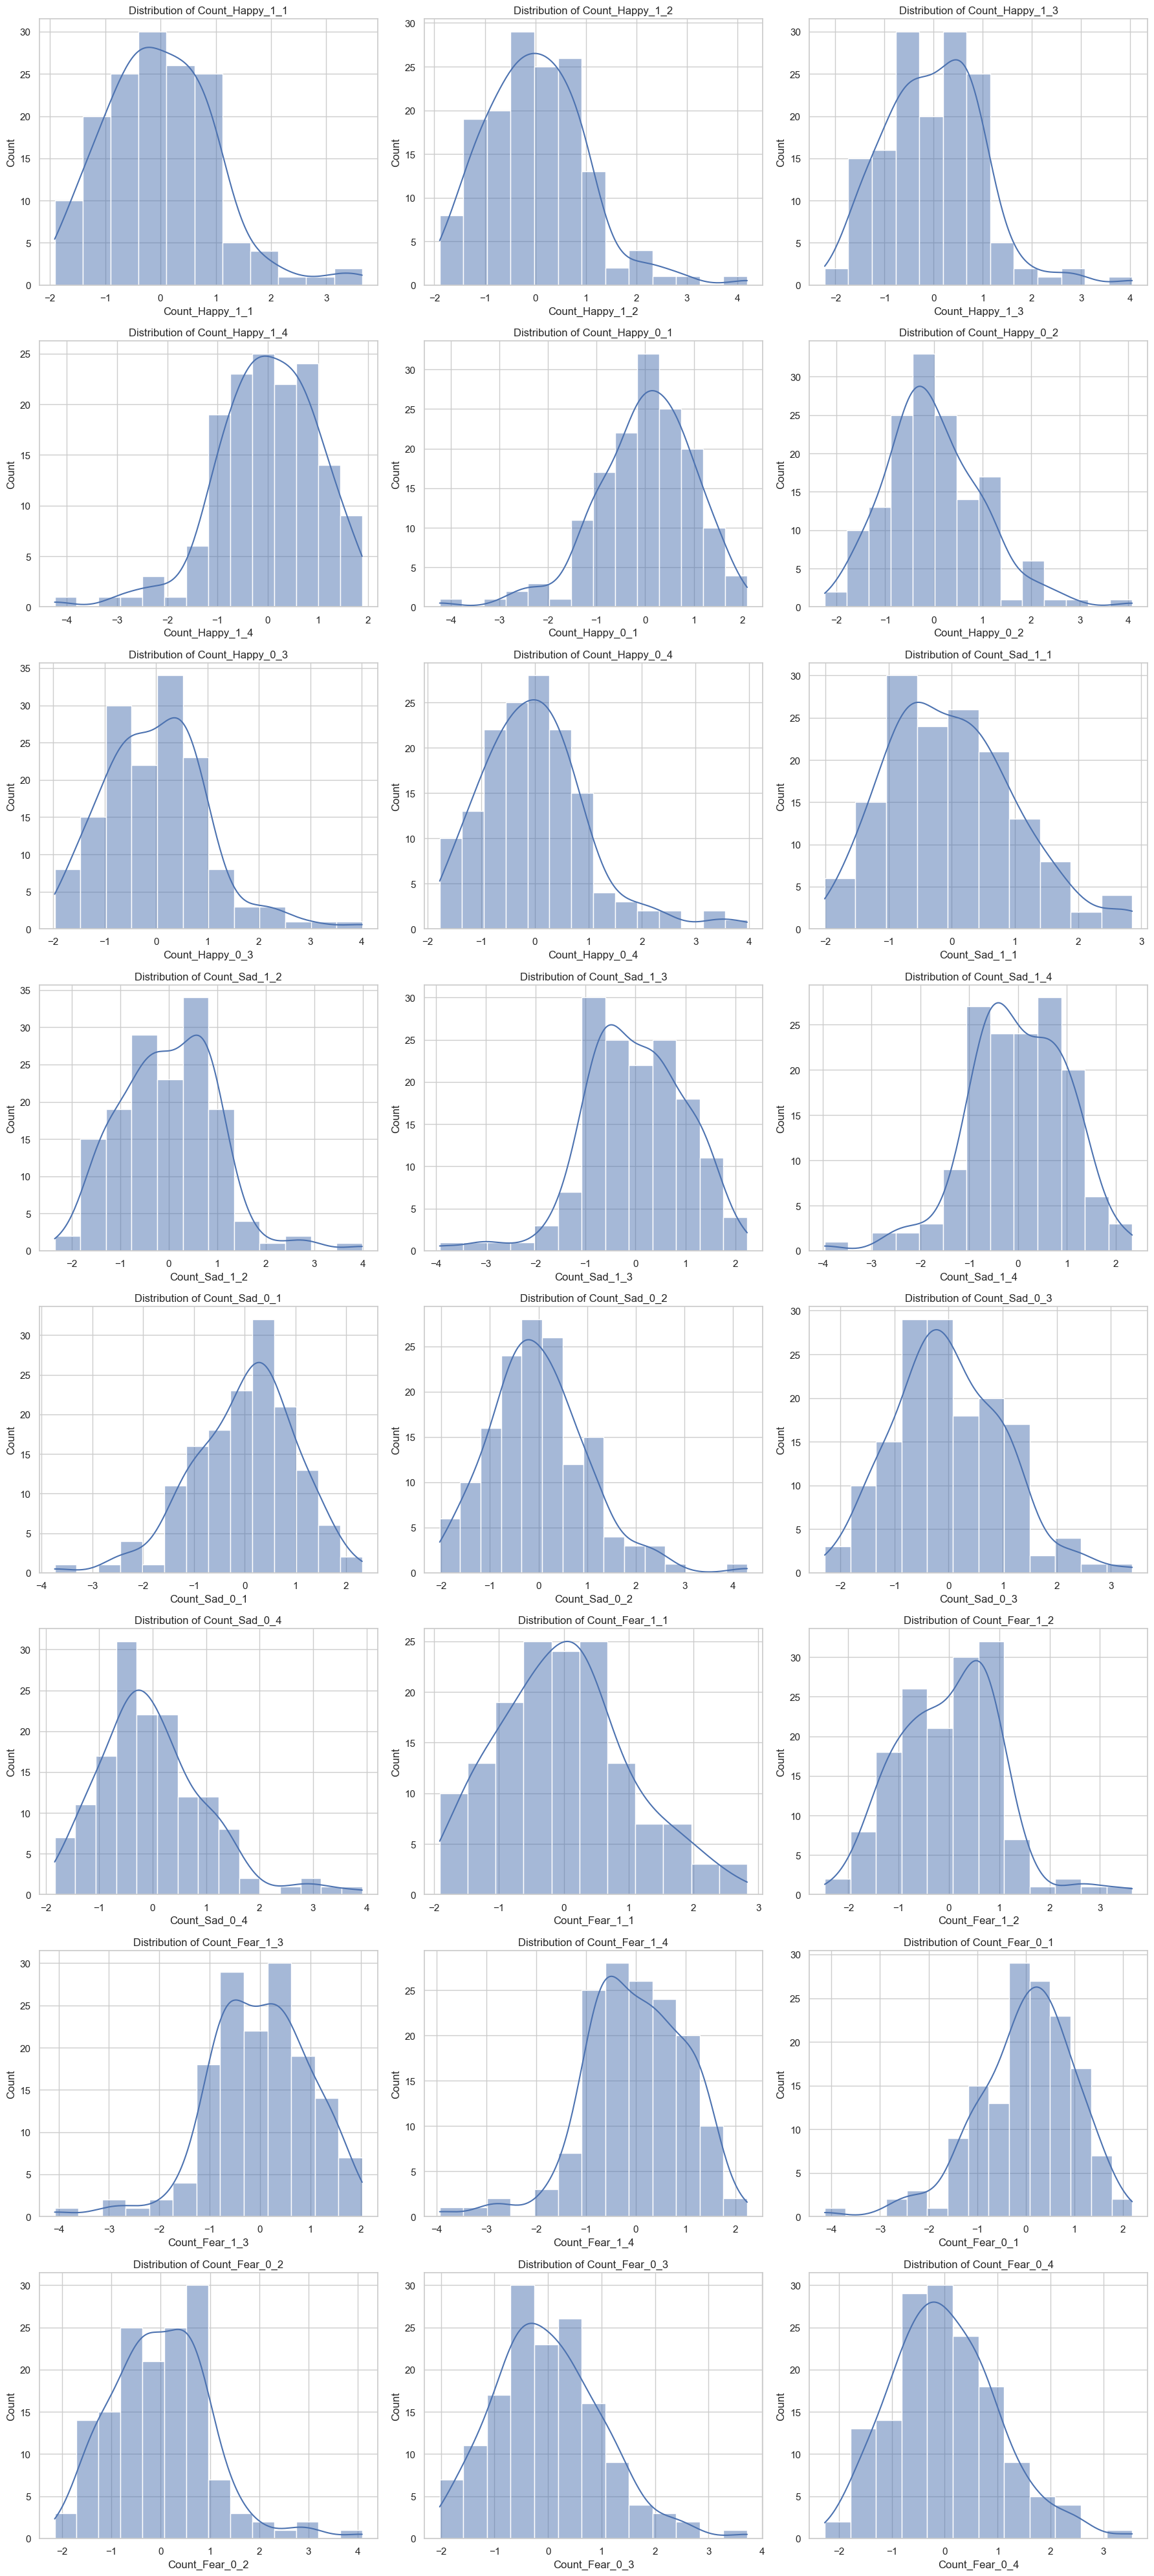

In [21]:
predictive_plots.plot_distributions(scaled_transformed_df)

#### Correlation of Transformed Data


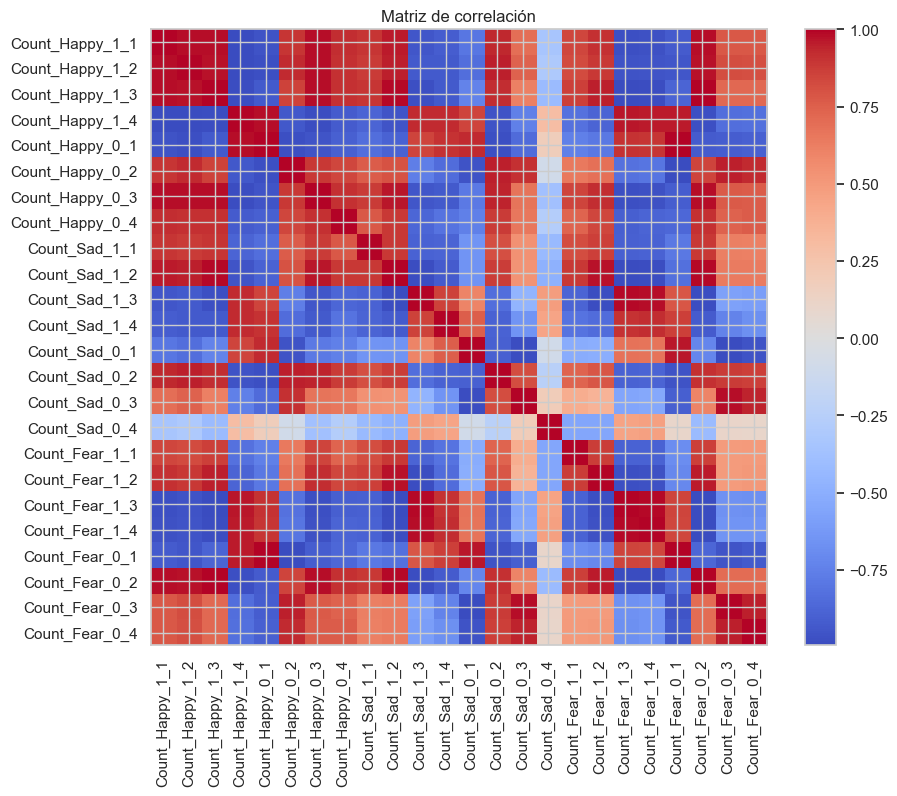

In [22]:
predictive_plots.plot_correlation(scaled_transformed_df)

## Clustering on Transformed Data

#### Hierarchical Clustering

In [23]:
silhouette = []
db = []
for n in range(2,20):
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    silhouette.append(silhouette_score(scaled_transformed_df.drop("Subject",axis=1), data_clusters))
    db.append(davies_bouldin_score(scaled_transformed_df.drop("Subject",axis=1), data_clusters))


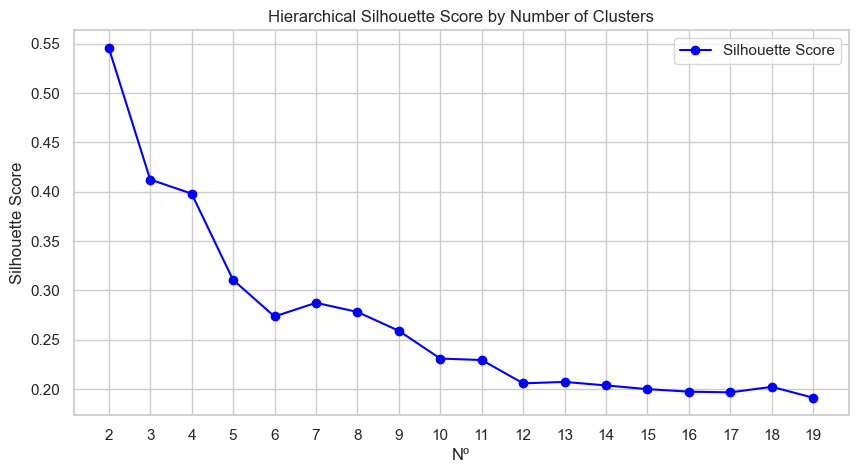

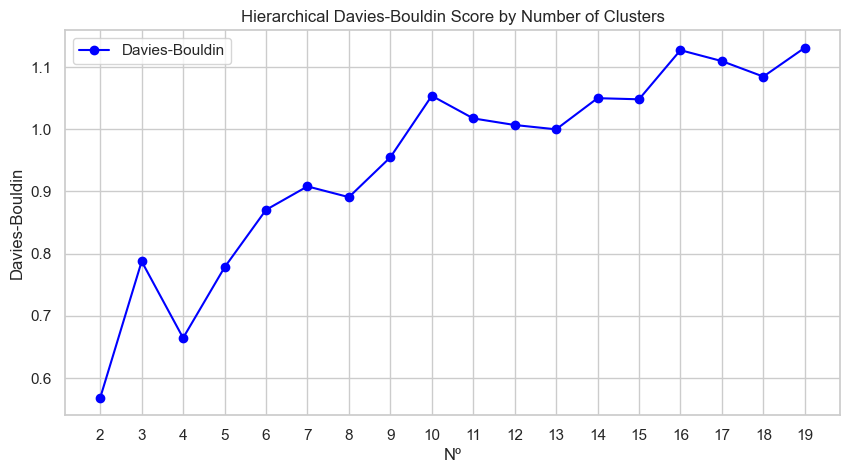

In [24]:
cluster_range = range(2, 20)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, silhouette,label,title)

cluster_range = range(2, 20)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Number of Clusters'
predictive_plots.metrics_plot(cluster_range, db,label,title)


In [25]:
for n in range(2,7):
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),AgglomerativeClustering,{'n_clusters':n,'linkage':"complete"},fit=True)
    df_cluster = pd.concat([scaled_transformed_df["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"count_hierarchical_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    output_name = f'Clusters_CountData/count_hierarchical_{n}_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)


#### OPTICS Clustering

In [37]:
silhouette = []
db = []
for n in range(2,8):
    
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    
    
    copy_df = scaled_transformed_df.drop("Subject",axis=1).copy()
    copy_df = pd.DataFrame(copy_df)

    copy_df["clusters"] = data_clusters
    copy_df = copy_df[copy_df["clusters"] != -1]
    silhouette.append(silhouette_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))
    db.append(davies_bouldin_score(copy_df.drop("clusters",axis=1), copy_df["clusters"]))


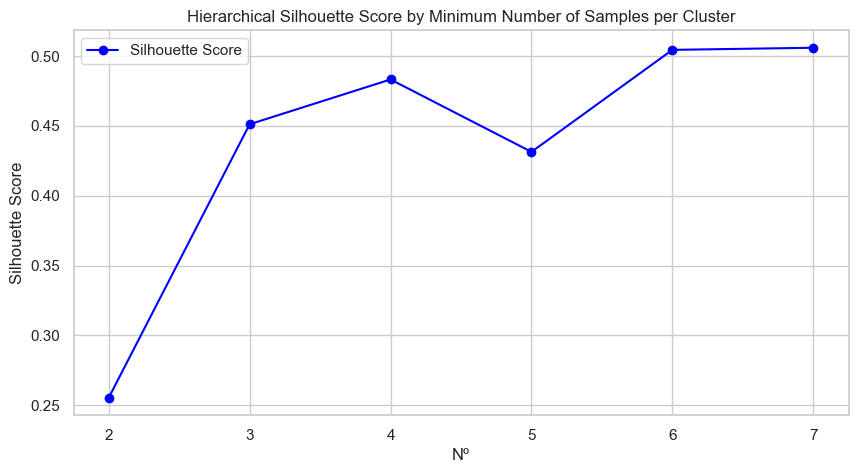

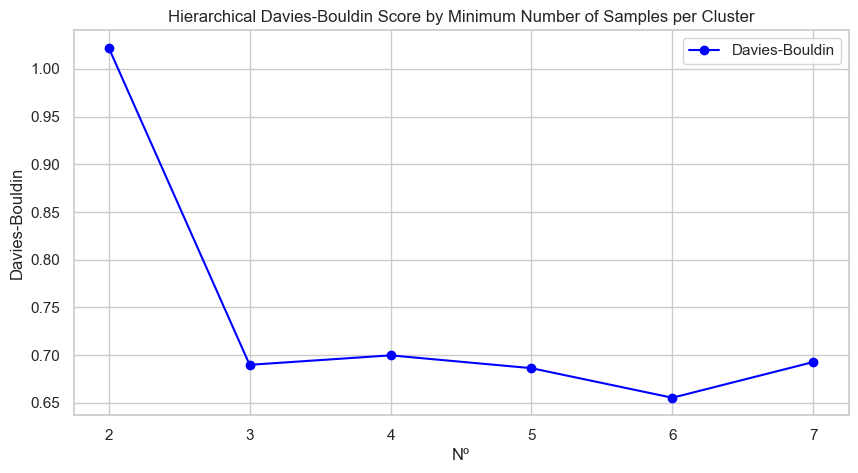

In [39]:

cluster_range = range(2, 8)
label = 'Silhouette Score'
title = 'Hierarchical Silhouette Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, silhouette, label, title)

cluster_range = range(2, 8)
label = 'Davies-Bouldin'
title = 'Hierarchical Davies-Bouldin Score by Minimum Number of Samples per Cluster'
predictive_plots.metrics_plot(cluster_range, db, label, title)


In [40]:
for n in range(4,8):
    data_clusters = predictive_clustering.clustering(scaled_transformed_df.drop("Subject",axis=1),OPTICS,{"min_samples":n, "metric":"euclidean", "algorithm":"auto"},fit=True)
    df_cluster = pd.concat([scaled_transformed_df["Subject"].copy(),pd.Series(data_clusters)],axis=1)
    df_cluster.columns = ["Subject","clusters"]
    name_output = f"count_optics_{n}_clusters.docx"
    new_data = pd.merge(scales.copy(), df_cluster.copy(), right_on='Subject', left_on='EPRIME_CODE')
    new_data.drop("Subject", axis=1, inplace=True)
    df = utils.filter_data(new_data)
    utils.create_word(df, list_metrics, name_output)
    
    output_name = f'Clusters_CountData/count_optics_{n}_per_clusters.xlsx'
    utils.export_clusters_df(df_cluster.copy(),output_name)